In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import Delaunay
import networkx as nx
import torch
from torch_geometric.nn import Node2Vec
from torch_geometric.utils import from_networkx
import os
import torch
import pickle
import psutil
from tqdm.notebook import tqdm

## Load the data

In [2]:
##select dir
import os
os.getcwd()
data_dir = Path("/ibex/scratch/medinils/breast_data/data/")

In [3]:
##load the data
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train = pd.read_csv(data_dir/"supplementary_data"/"train_metadata.csv")
df_test = pd.read_csv(data_dir/"supplementary_data/test_metadata.csv")

# concatenate y_train and df_train
y_train = pd.read_csv(data_dir  / "train_output.csv")
df_train = df_train.merge(y_train, on="Sample ID")

print(f"Training data dimensions: {df_train.shape}")  # (344, 4)
df_train.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

In [4]:
#create a graph dic to store them
graphs = {}

X_train = []
y_train = []
centers_train = []
patients_train = []

for sample, patient, center, label in tqdm(
    df_train[["Sample ID", "Patient ID", "Center ID", "Target"]].values
):
    # coordinates and features each iteration one sample
    _features = np.load(train_features_dir / sample)
    # coo and features, separate them
    coo, features = _features[:, 1:3], _features[:, 3:]
    # delaunay triangulation
    tri = Delaunay(coo)
    # Create the graph to add the
    G = nx.Graph()

    # add the edges for each Delaunay triangulation
    for tri in tri.simplices:
        for i in range(3):
            for j in range(i+1, 3):
                # add the edge between the i-th and j-th point in the triangle
                # the edge weight is the euclidean distance
                p1 = coo[tri[i]]
                p2 = coo[tri[j]]
                distance = np.linalg.norm(p1 - p2)
                G.add_edge(tri[i], tri[j], weight =distance)
                # add features as node attributes
                G.nodes[tri[i]].update({'features': features[tri[i]]})
                G.nodes[tri[j]].update({'features': features[tri[j]]})
                # Add the target label to the graph's attributes
                G.graph['label'] = label
                G.graph['patient_id'] = patient
                G.graph['sample_id'] = sample
                G.graph['center_id'] = center
    # store the graphs for each patient (key)
    graphs[patient] = G
    
    # Slide-level averaging
    X_train.append(np.mean(features, axis=0))
    y_train.append(label)
    centers_train.append(center)
    patients_train.append(patient)

  0%|          | 0/344 [00:00<?, ?it/s]

Number of nodes (tiles) 1000


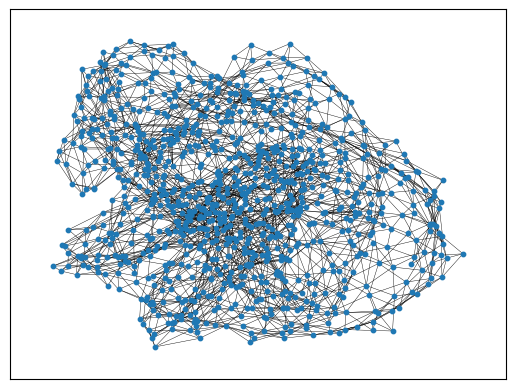

In [6]:
## check the first graph
G1 = next(iter(graphs.values()))
print("Number of nodes (tiles)", len(G1.nodes))

# Calculate the layout with more spacing
pos = nx.spring_layout(G1, k=0.10)
nx.draw_networkx(G1, pos, node_size=10, width= 0.3,with_labels=False)
plt.show()

features = G1.nodes[1]["features"]


In [5]:
#save it
save_path = "/ibex/scratch/medinils/breast_data/data/process/graphs.pkl"
with open(save_path, "wb") as f:
    pickle.dump(graphs, f)

# Load the dictionary
save_path = "/ibex/scratch/medinils/breast_data/data/process/graphs.pkl"
with open(save_path, 'rb') as file:
    graphs = pickle.load(file)

## Node2Vec


In [ ]:
# Convert your networkx graphs to PyTorch Geometric data objects
data_list = [from_networkx(graph) for graph in graphs.values()]

# convert node atributes to tensors
for data in data_list:
    for key, item in data:
        if isinstance(item, np.ndarray):
            data[key] = torch.tensor(item)

# save the list
save_path = "/ibex/scratch/medinils/breast_data/data/process/data_list.pt"
torch.save(data_list, save_path)
# read the list
save_path = "/ibex/scratch/medinils/breast_data/data/process/data_list.pt"
data_list = torch.load(save_path)

In [ ]:
import psutil
def memory_usage():
    process = psutil.Process(os.getpid())
    return f"Memory usage: {process.memory_info().rss / (1024 ** 3):.2f} GB"

# Example usage:
print(memory_usage())

In [30]:
# Dictionary to store embeddings for each graph
graph_embeddings = {}
# Initialize a counter to keep track of processed graphs
processed_graphs = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop through each graph in the subset and generate embeddings
for patient, data in tqdm(zip(graphs.keys(), data_list), total=len(data_list), desc="Processing Graphs"):

    # Initialize Node2Vec model with num_negative_samples parameter
    model = Node2Vec(data.edge_index, embedding_dim=64, walk_length=15,
                     context_size=5, walks_per_node=150, num_negative_samples=5).to(device)
    loader = model.loader(batch_size=64, shuffle=True, num_workers=4)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    model.train()
        for epoch in tqdm(range(50), desc="Training Node2Vec", leave=False):
        total_loss = 0  # To compute average loss over all batches
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")

    # Get embeddings for all nodes
    model.eval()
    with torch.no_grad():
        embeddings = model()

    # Aggregate the embeddings using mean (or any other method you choose)
    aggregated_embedding = embeddings.mean(dim=0).cpu().detach().numpy()

    # Store aggregated embeddings in the dictionary
    graph_embeddings[patient] = aggregated_embedding

    # Increment the counter and print it
    processed_graphs += 1
    print(f"Processed {processed_graphs} graphs.")

    # Print memory usage
    print(memory_usage())

# Specify the path for saving
save_path = "/ibex/scratch/medinils/breast_data/data/embeddings/graph_embeddings.npy"

# Save the embeddings to the specified path
np.save(save_path, graph_embeddings)

IndentationError: unexpected indent (1215363906.py, line 19)

In [8]:
save_path = "/ibex/scratch/medinils/breast_data/data/embeddings/graph_embeddings.npy"
# Load the embeddings back from the saved file
graph_embeddings = np.load(save_path, allow_pickle=True)

In [11]:
X_train = np.vstack(X_train)
print(X_train.shape)
y_train = np.array(y_train)
print(y_train.shape)

(344, 2048)
(344,)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

graph_dict = graph_embeddings.item()
print("Sample keys from graph_dict:", list(graph_dict.keys())[:5])

# Replace the slide-level averaging with graph embeddings
# Filter the patients_train, y_train, and centers_train lists to include only patients
# for whom you have graph embeddings
filtered_indices = [i for i, patient in enumerate(patients_train) if patient in graph_dict]

X_train = [graph_dict[patients_train[i]] for i in filtered_indices]
y_train = [y_train[i] for i in filtered_indices]
centers_train = [centers_train[i] for i in filtered_indices]
patients_train = [patients_train[i] for i in filtered_indices]

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
centers_train = np.array(centers_train)
patients_train = np.array(patients_train)

# Unique patients for stratified K-fold
patients_unique = np.unique(patients_train)
y_train_unique = np.array([np.mean(y_train[patients_train == p]) for p in patients_unique])

# Define the models
models = {
    "Logistic Regression": LogisticRegression(C=0.005, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
}

# For storing results
results = {model_name: [] for model_name in models}

# Unique patients
patients_unique = np.unique(patients_train)
y_unique = np.array([np.mean(y_train[patients_train == p]) for p in patients_unique])

for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
        train_idx = np.where(np.isin(patients_train, patients_unique[train_idx_]))[0]
        val_idx = np.where(np.isin(patients_train, patients_unique[val_idx_]))[0]

        X_fold_train, y_fold_train = X_train[train_idx], y_train[train_idx]
        X_fold_val, y_fold_val = X_train[val_idx], y_train[val_idx]

        for model_name, model in models.items():
            model.fit(X_fold_train, y_fold_train)
            preds_val = model.predict_proba(X_fold_val)[:, 1]
            auc = roc_auc_score(y_fold_val, preds_val)
            results[model_name].append(auc)
            print(f"{model_name} - Split {k}: AUC: {auc:.3f}")

    print("----------------------------")

for model_name in models:
    print(f"\n{model_name} Results:")
    print(f"AUC: {np.mean(results[model_name]):.3f} ± {np.std(results[model_name]):.3f}")



# Print number of unique patients
print(f"Number of unique patients: {len(np.unique(patients_train))}")

# Print total number of samples
print(f"Total number of samples: {len(X_train)}")


Sample keys from graph_dict: ['P_001', 'P_002', 'P_005', 'P_006', 'P_007']
Logistic Regression - Split 0: AUC: 0.447
Random Forest - Split 0: AUC: 0.513
Logistic Regression - Split 0: AUC: 0.493
Random Forest - Split 0: AUC: 0.514
Logistic Regression - Split 0: AUC: 0.603
Random Forest - Split 0: AUC: 0.551
Logistic Regression - Split 0: AUC: 0.463
Random Forest - Split 0: AUC: 0.410
Logistic Regression - Split 0: AUC: 0.528
Random Forest - Split 0: AUC: 0.545
----------------------------
Logistic Regression - Split 1: AUC: 0.457
Random Forest - Split 1: AUC: 0.491
Logistic Regression - Split 1: AUC: 0.454
Random Forest - Split 1: AUC: 0.450
Logistic Regression - Split 1: AUC: 0.464
Random Forest - Split 1: AUC: 0.432
Logistic Regression - Split 1: AUC: 0.629
Random Forest - Split 1: AUC: 0.614
Logistic Regression - Split 1: AUC: 0.540
Random Forest - Split 1: AUC: 0.507
----------------------------
Logistic Regression - Split 2: AUC: 0.575
Random Forest - Split 2: AUC: 0.582
Logistic 

In [15]:
from sklearn.ensemble import RandomForestClassifier


# Define the models
models = {
    "Logistic Regression": LogisticRegression(C=0.005, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=15, max_depth=1, random_state=0)
}

# 5-fold CV is repeated 5 times with different random states
results = {model_name: {"Train_AUC": [], "Val_AUC": [], "Accuracy": [], "Precision": []} for model_name in models}

patients_unique = np.unique(patients_train)

for k in range(5):
    kfold = StratifiedKFold(5, shuffle=True, random_state=k)
    fold = 0
    # Split is performed at the patient-level
    for train_idx_, val_idx_ in kfold.split(patients_unique, y_train_unique):
        train_idx = np.arange(len(X_train))[np.isin(patients_train, patients_unique[train_idx_])]
        val_idx = np.arange(len(X_train))[np.isin(patients_train, patients_unique[val_idx_])]

        # Split data
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        for model_name, model in models.items():
            # Train model
            model.fit(X_fold_train, y_fold_train)

            # Predictions on validation data
            preds_val = model.predict_proba(X_fold_val)[:, 1]
            # Predictions on training data
            preds_train = model.predict_proba(X_fold_train)[:, 1]

            # Compute metrics for validation data
            val_auc = roc_auc_score(y_fold_val, preds_val)
            acc = accuracy_score(y_fold_val, (preds_val > 0.5).astype(int))
            precision = precision_score(y_fold_val, (preds_val > 0.5).astype(int))

            # Compute AUC for training data
            train_auc = roc_auc_score(y_fold_train, preds_train)

            # Store results
            results[model_name]["Train_AUC"].append(train_auc)
            results[model_name]["Val_AUC"].append(val_auc)
            results[model_name]["Accuracy"].append(acc)
            results[model_name]["Precision"].append(precision)

            print(f"{model_name} - Split {k} Fold {fold}: Train AUC: {train_auc:.3f}, Val AUC: {val_auc:.3f}, Accuracy: {acc:.3f}, Precision: {precision:.3f}")

        fold += 1
    print("----------------------------")

# Compute average results
for model_name in models:
    print(f"\n{model_name} Results:")
    print(f"Train AUC: {np.mean(results[model_name]['Train_AUC']):.3f} ± {np.std(results[model_name]['Train_AUC']):.3f}")
    print(f"Val AUC: {np.mean(results[model_name]['Val_AUC']):.3f} ± {np.std(results[model_name]['Val_AUC']):.3f}")
    print(f"Accuracy: {np.mean(results[model_name]['Accuracy']):.3f} ± {np.std(results[model_name]['Accuracy']):.3f}")
    print(f"Precision: {np.mean(results[model_name]['Precision']):.3f} ± {np.std(results[model_name]['Precision']):.3f}")



/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Logistic Regression - Split 0 Fold 0: Train AUC: 0.764, Val AUC: 0.447, Accuracy: 0.614, Precision: 0.000
Random Forest - Split 0 Fold 0: Train AUC: 0.750, Val AUC: 0.475, Accuracy: 0.614, Precision: 0.000
Logistic Regression - Split 0 Fold 1: Train AUC: 0.767, Val AUC: 0.493, Accuracy: 0.646, Precision: 0.000
Random Forest - Split 0 Fold 1: Train AUC: 0.793, Val AUC: 0.465, Accuracy: 0.646, Precision: 0.000
Logistic Regression - Split 0 Fold 2: Train AUC: 0.762, Val AUC: 0.603, Accuracy: 0.632, Precision: 0.000
Random Forest - Split 0 Fold 2: Train AUC: 0.773, Val AUC: 0.481, Accuracy: 0.632, Precision: 0.000
Logistic Regression - Split 0 Fold 3: Train AUC: 0.788, Val AUC: 0.463, Accuracy: 0.616, Precision: 0.000
Random Forest - Split 0 Fold 3: Train AUC: 0.791, Val AUC: 0.488, Accuracy: 0.616, Precision: 0.000
Logistic Regression - Split 0 Fold 4: Train AUC: 0.753, Val AUC: 0.528, Accuracy: 0.632, Precision: 0.000
Random Forest - Split 0 Fold 4: Train AUC: 0.740, Val AUC: 0.515, Accu

/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Random Forest - Split 2 Fold 0: Train AUC: 0.767, Val AUC: 0.503, Accuracy: 0.612, Precision: 0.000
Logistic Regression - Split 2 Fold 1: Train AUC: 0.773, Val AUC: 0.511, Accuracy: 0.647, Precision: 0.000
Random Forest - Split 2 Fold 1: Train AUC: 0.739, Val AUC: 0.463, Accuracy: 0.647, Precision: 0.000
Logistic Regression - Split 2 Fold 2: Train AUC: 0.772, Val AUC: 0.574, Accuracy: 0.632, Precision: 0.000
Random Forest - Split 2 Fold 2: Train AUC: 0.764, Val AUC: 0.450, Accuracy: 0.632, Precision: 0.000
Logistic Regression - Split 2 Fold 3: Train AUC: 0.772, Val AUC: 0.517, Accuracy: 0.606, Precision: 0.000
Random Forest - Split 2 Fold 3: Train AUC: 0.727, Val AUC: 0.357, Accuracy: 0.606, Precision: 0.000
Logistic Regression - Split 2 Fold 4: Train AUC: 0.750, Val AUC: 0.525, Accuracy: 0.643, Precision: 0.000
Random Forest - Split 2 Fold 4: Train AUC: 0.769, Val AUC: 0.444, Accuracy: 0.657, Precision: 1.000
----------------------------
Logistic Regression - Split 3 Fold 0: Train AUC

/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m

Random Forest - Split 3 Fold 1: Train AUC: 0.767, Val AUC: 0.497, Accuracy: 0.662, Precision: 0.000
Logistic Regression - Split 3 Fold 2: Train AUC: 0.776, Val AUC: 0.289, Accuracy: 0.618, Precision: 0.000
Random Forest - Split 3 Fold 2: Train AUC: 0.770, Val AUC: 0.395, Accuracy: 0.618, Precision: 0.000
Logistic Regression - Split 3 Fold 3: Train AUC: 0.751, Val AUC: 0.567, Accuracy: 0.623, Precision: 0.000
Random Forest - Split 3 Fold 3: Train AUC: 0.738, Val AUC: 0.510, Accuracy: 0.623, Precision: 0.000
Logistic Regression - Split 3 Fold 4: Train AUC: 0.777, Val AUC: 0.474, Accuracy: 0.618, Precision: 0.000
Random Forest - Split 3 Fold 4: Train AUC: 0.762, Val AUC: 0.391, Accuracy: 0.618, Precision: 0.000
----------------------------
Logistic Regression - Split 4 Fold 0: Train AUC: 0.773, Val AUC: 0.573, Accuracy: 0.648, Precision: 0.000
Random Forest - Split 4 Fold 0: Train AUC: 0.780, Val AUC: 0.622, Accuracy: 0.648, Precision: 0.000
Logistic Regression - Split 4 Fold 1: Train AUC

/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/medinils/pytorch-gpu-data-science-project/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/m